# Case Study 4 : Data Science in Any Data You Like

Kevin Martin, Pascal Bakker, Mario Arduz Rejas, Kevin Bimonte

**Required Readings:** 
* In this case study, you could use any data as you like.
* [TED Talks](https://www.ted.com/talks) for examples of 7 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using your Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In recent years, the avocado industry has exploded - with Americans eating over 2.4 billion avocados per year.  These avocados come from all over the United States, and are consumed in a multitude of ways.  

The data we looked at represents weekly retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

We plan to build a price prediction model using ARIMA, as well as a classifier that will predict whether or not an avocado sold is organic or non-organic.

# Data Collection/Processing: 

In [2]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
# Import packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('avocado.csv')


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
data.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

There is no missing data in this dataset, which is convenient for us!

# Data Exploration: Exploring the your data

** plot some properties/statistics/distribution of your data** 

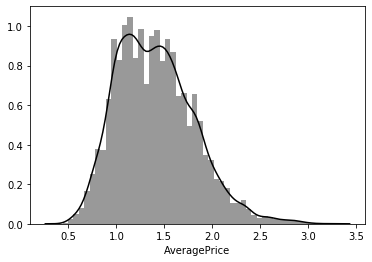

In [5]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
sns.distplot(data["AveragePrice"], color = 'k')


<function matplotlib.pyplot.show(*args, **kw)>

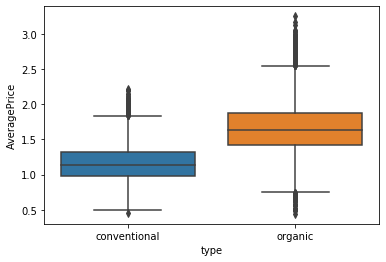

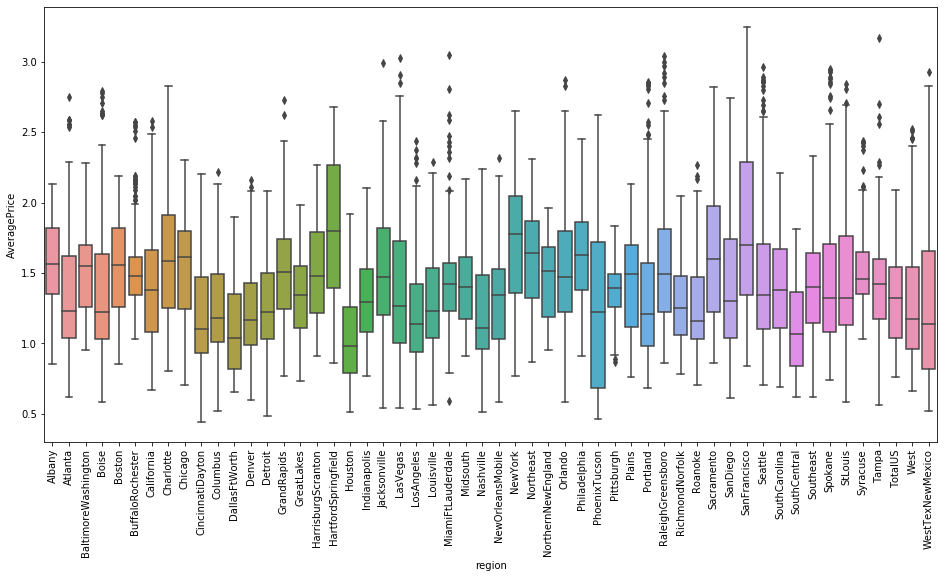

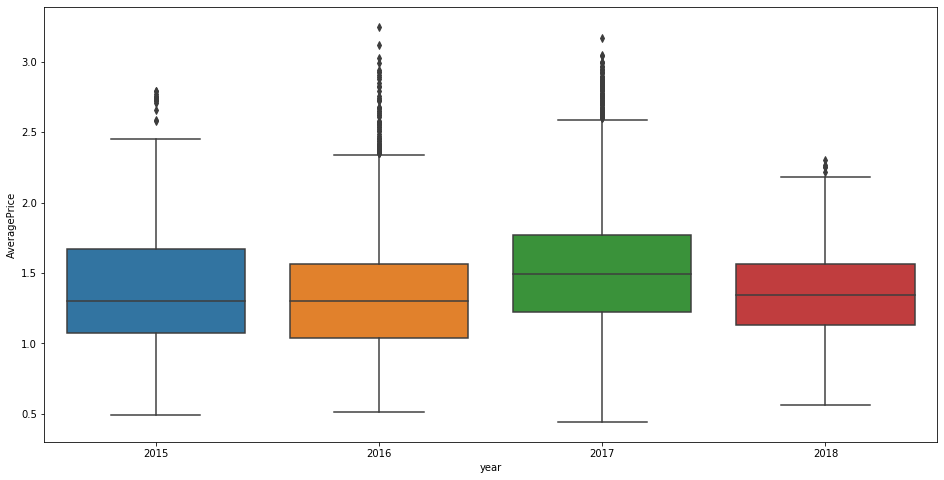

In [6]:
sns.boxplot(y='AveragePrice',x='type',data=data)
f,ax = plt.subplots(figsize=(16,8))
sns.boxplot(y='AveragePrice',x='region',data=data)
plt.xticks(rotation='vertical')
f,ax = plt.subplots(figsize=(16,8))
sns.boxplot(y='AveragePrice',x='year',data=data)
plt.show

Organic avocados are more expensive, which is expected since cultivating them is a more intensive process. The region seems to have some effect on the price of the avocado as the price varies per region. Each year the price of avocados is about the same, besides 2017 where there was a notable shortage of avocados.

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

ARIMA price prediction and organic vs non-organic classifier

Write codes to implement the solution in python:

In [8]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Encoding type as 0 or 1
label = LabelEncoder()
dicts = {}

label.fit(data.type.drop_duplicates()) 
dicts['type'] = list(label.classes_)
data.type = label.transform(data.type) 


In [12]:
#ARIMA Price Prediction

data2 = data.set_index(data.Date)
endog = data2.AveragePrice
exog = data.drop(['region','Unnamed: 0','Date','AveragePrice','year'],axis=1)
exog = exog.set_index(data.Date)
model = ARIMA(endog=endog, order=(5,1,0), exog=exog)
model_fit = model.fit(disp=0)
arima_pred = model.predict(data2.AveragePrice)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.AveragePrice   No. Observations:                18248
Model:                 ARIMA(5, 1, 0)   Log Likelihood                6863.754
Method:                       css-mle   S.D. of innovations              0.166
Date:                Wed, 20 Nov 2019   AIC                         -13695.508
Time:                        17:21:39   BIC                         -13570.519
Sample:                             1   HQIC                        -13654.433
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0010      0.001      1.022      0.307      -0.001       0.003
Total Volume          9.668e-06        nan        nan        nan         nan         nan
4046        

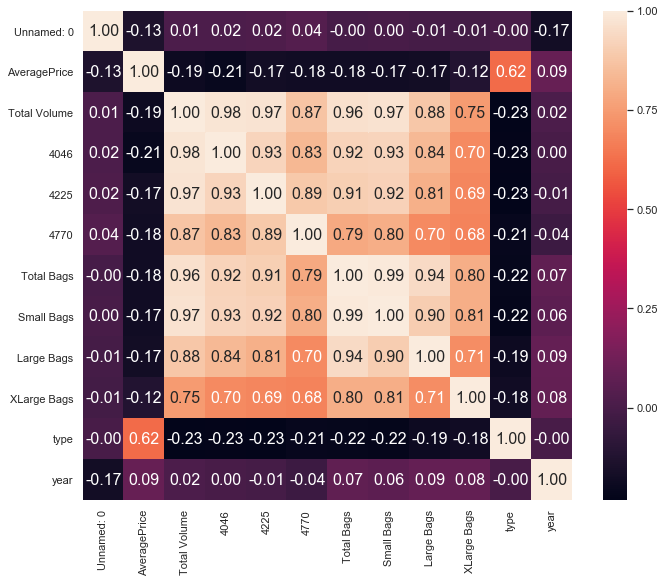

In [14]:
# Correlation Heatmap
corr = data.corr()
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(11, 9))
hm = sns.heatmap(corr,cbar = True, annot = True,square = True, fmt = '.2f', annot_kws = {'size':16})

In [15]:
x = data.drop(['type','region','Date'], axis = 1) #dropping type and categorical variables
y = data.type
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 0,test_size=0.3)
print(x_train.shape,x_test.shape)
x.head()

(12774, 11) (5475, 11)


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
0,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015
1,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015
2,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015
3,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015
4,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015


In [16]:
logreg =  LogisticRegression(penalty='l1', tol=0.0001).fit(x_train,y_train)
logpredict = logreg.predict(x_test)
c = confusion_matrix(logpredict,y_test)
print("Predicted",c[0][0],"conventional correctly and",c[0][1],"incorrectly")
print("Predicted",c[1][1],"organic correctly and",c[1][0],"incorrectly")
print("Overall Accuracy Rate:",(c[0][0]+c[1][1])/(c[0][0]+c[1][1]+c[0][1]+c[1][0]))
print("Conventional Prediction Accuracy:",c[0][0]/(c[0][0]+c[0][1]))
print("Organic Prediction Accuracy:",c[1][1]/(c[1][1]+c[1][0]))

Predicted 2515 conventional correctly and 68 incorrectly
Predicted 2681 organic correctly and 211 incorrectly
Overall Accuracy Rate: 0.949041095890411
Conventional Prediction Accuracy: 0.9736740224545103
Organic Prediction Accuracy: 0.9270401106500692


In [17]:
rf =  RandomForestClassifier(n_estimators = 100, random_state = 0, max_features = 2)
rf.fit(x_train,y_train)
rfpredict = rf.predict(x_test)
c = confusion_matrix(rfpredict,y_test)
print("Predicted",c[0][0],"conventional correctly and",c[0][1],"incorrectly")
print("Predicted",c[1][1],"organic correctly and",c[1][0],"incorrectly")
print("Overall Accuracy Rate:",(c[0][0]+c[1][1])/(c[0][0]+c[1][1]+c[0][1]+c[1][0]))
print("Conventional Prediction Accuracy:",c[0][0]/(c[0][0]+c[0][1]))
print("Organic Prediction Accuracy:",c[1][1]/(c[1][1]+c[1][0]))

Predicted 2714 conventional correctly and 21 incorrectly
Predicted 2728 organic correctly and 12 incorrectly
Overall Accuracy Rate: 0.993972602739726
Conventional Prediction Accuracy: 0.9923217550274223
Organic Prediction Accuracy: 0.9956204379562044


In [19]:
kfold = 5
knn = KNeighborsClassifier(n_neighbors = 200) 
knn.fit(x_train, y_train)
knnpredict = knn.predict(x_test)
c = confusion_matrix(knnpredict,y_test)
print("Predicted",c[0][0],"conventional correctly and",c[0][1],"incorrectly")
print("Predicted",c[1][1],"organic correctly and",c[1][0],"incorrectly")
print("Overall Accuracy Rate:",(c[0][0]+c[1][1])/(c[0][0]+c[1][1]+c[0][1]+c[1][0]))
print("Conventional Prediction Accuracy:",c[0][0]/(c[0][0]+c[0][1]))
print("Organic Prediction Accuracy:",c[1][1]/(c[1][1]+c[1][0]))


Predicted 2647 conventional correctly and 249 incorrectly
Predicted 2500 organic correctly and 79 incorrectly
Overall Accuracy Rate: 0.9400913242009132
Conventional Prediction Accuracy: 0.9140193370165746
Organic Prediction Accuracy: 0.9693679720822024


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


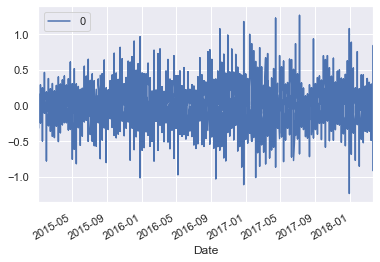

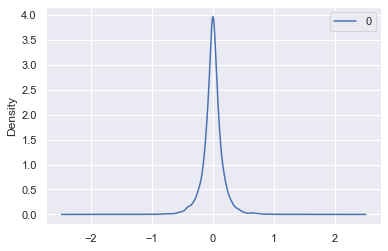

                  0
count  18248.000000
mean       0.000009
std        0.166120
min       -1.232899
25%       -0.072356
50%        0.000854
75%        0.072823
max        1.258457


In [13]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
# plot residual errors

# ARIMA Results
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())






Random forest classifier worked the best, with 99% prediction accuracy overall

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 7 minutes' talk) to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 4".
        
** Note: Each team only needs to submit one submission in Canvas **